# Machine Learning COS-623 - Terceiro Trimestre de 2017
## Terceira e Quarta Listas de Exercı́cios (Graduação e Pós-Graduação)



In [52]:
import numpy as np # manipulação de matrizes
import pandas as pd # Manipulação de datasets
import matplotlib.pyplot as plt # Para plotagem
import seaborn as sns # Coloração melhor nas plotagens
import scipy.stats as stats # Normalizações, cálculos de densidade de probabilidade, etc
import sklearn # Implementação de modelos preditivos e de classificação

%matplotlib inline

In [51]:
## Lendo o dataset e separando os dados em 1000 dados de treino e 172 dados de teste
df = pd.read_csv("Dados-medicos.txt",sep=" ")
df = df.drop('Unnamed: 1', 1) ## removendo coluna gerado errôneamentod devido à formatação dos dados
df = df.drop('Unnamed: 2', 1) ## removendo coluna gerado errôneamentod devido à formatação dos dados

train = df.sample(frac = 0.85324232082,random_state=200)
test  = df.drop(train.index)

### Funções de apoio para primeira questão

Vamos definir uma função para executar o modelo de Regressão Linear, bem como analisar seu desempenho ao manipular as variáveis de entrada X e também plotar seu resultado final.

In [63]:
from sklearn.linear_model import LinearRegression ## Modelo de regressão linear
from sklearn.preprocessing import PolynomialFeatures ## Geração de features para modelos

def do_rmse(y,y_predicted):
    return np.sqrt(np.mean((y - y_predicted) **2 ))

def negativeLogLikelihood(testDataset,variance,y,y_predicted):
    return -(len(testDataset)/2)*np.log(2*np.pi*variance) - (1/(2*variance))* np.sum((y - y_predicted) **2 )

def linear_regression(train,test,variables,target,polyDegree):
    ## Vamos criar X_ e test_ para ser datasets que possuem os valores das nossas variaveis x (carga) elevado a n

    data = train[variables]
    X_ = data.drop(target, axis = 1)

    testData = test[variables]
    test_ = testData.drop(target, axis = 1)

    polyDegree = 4
    poly = PolynomialFeatures(degree=polyDegree)

    X_ = poly.fit_transform(X_)

    test_ = poly.fit_transform(test_)

    X_ = pd.DataFrame(data=X_[0:,0:],index=X_[0:,0])

    test_ = pd.DataFrame(data=test_[0:,0:],index=test_[0:,0]) 

    ## Executando uma regressao polinomial para cada grau de polinomio <= polyDegree
    lm = LinearRegression()
    for i in range (1,polyDegree+1):
        X = X_.iloc[:,0:i+1]
        test_X = test_.iloc[:,0:i+1]
        lm.fit(X,data.VO2_medido_máximo)
        print(pd.DataFrame(list(zip(X.columns,lm.coef_)),columns = ['features','w']))
        rmse = do_rmse(test.VO2_medido_máximo,lm.predict(test_X))
        print("O RMSE com polinômio de grau %i foi de %f" % (i,rmse)) 
        var = test[['VO2_medido_máximo']].var().values[0]
        nll = negativeLogLikelihood(test,var,test.VO2_medido_máximo,lm.predict(test_X))
        print("O NLL com polinômio de grau %i foi de %f \n" % (i,nll)) 

    # plots graph
    
    y = train[['VO2_medido_máximo']].values
    x = train[['Carga_Final']].values
    plt.scatter(x,y)
    plt.plot(x, lm.predict(poly.fit_transform(x)), color='blue', linewidth=3)

    plt.grid(True)
    plt.savefig("test.png")
    plt.show()
    

## Questão 1

### 1.1

   features         w
0         0  0.000000
1         1  0.133087
O RMSE com polinômio de grau 1 foi de 5.248248
O NLL com polinômio de grau 1 foi de -571.207806 

   features         w
0         0  0.000000
1         1  0.135884
2         2 -0.000007
O RMSE com polinômio de grau 2 foi de 5.239117
O NLL com polinômio de grau 2 foi de -571.116067 

   features             w
0         0  0.000000e+00
1         1  1.238605e-01
2         2  6.021022e-05
3         3 -1.115425e-07
O RMSE com polinômio de grau 3 foi de 5.243538
O NLL com polinômio de grau 3 foi de -571.160462 

   features             w
0         0  0.000000e+00
1         1  2.163564e-01
2         2 -7.686770e-04
3         3  2.795914e-06
4         4 -3.451295e-09
O RMSE com polinômio de grau 4 foi de 5.264564
O NLL com polinômio de grau 4 foi de -571.372131 



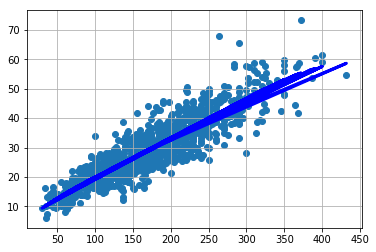

In [64]:
linear_regression(train,test,['Carga_Final','VO2_medido_máximo'],['VO2_medido_máximo'],4)

### Questão 1.2

In [ ]:
# Vamos criar trainFeatures e testFeatures e aplicar sobre eles as transformações dados pelas base functions
# E.g., Para duas features a e b, para um polinomio de grau 2, as funções base serão:
# [1, a, b, a^2, ab, b^2]

trainData = train[['Peso', 'Carga_Final','VO2_medido_máximo']]
trainFeatures = trainData.drop('VO2_medido_máximo', axis = 1)

testData = test[['Peso', 'Carga_Final','VO2_medido_máximo']]
testFeatures = testData.drop('VO2_medido_máximo', axis = 1)

polyDegree = 4

# executa para todos os graus de 1 até polyDegree
for i in range (1,polyDegree+1):
    poly = PolynomialFeatures(degree=i)
    X = poly.fit_transform(trainFeatures)
    test_X = poly.fit_transform(testFeatures)

    X = pd.DataFrame(data=X[0:,0:],index=X[0:,0])
    test_X = pd.DataFrame(data=test_X[0:,0:],index=test_X[0:,0]) 

    lm = LinearRegression()
    lm.fit(X,trainData.VO2_medido_máximo)
    print(pd.DataFrame(list(zip(X.columns,lm.coef_)),columns = ['features','w']))
    rmse =  np.sqrt(np.mean( (test.VO2_medido_máximo - lm.predict(test_X) ) **2 ))
    print("O RMSE com polinômio de grau %i foi de %f" % (i,rmse)) 
    var = test[['VO2_medido_máximo']].var()
    nll = -(len(test)/2)*np.log(2*np.pi*var) - (1/(2*var))* np.sum( (test.VO2_medido_máximo - lm.predict(test_X) ) **2 )
    print("O NLL com polinômio de grau %i foi de %f \n" % (i,nll)) 

### Questão 1.3

In [ ]:
# Identical solution as question 1.2, but including the new feature age
trainData = train[['IDADE', 'Peso', 'Carga_Final','VO2_medido_máximo']]
trainFeatures = trainData.drop('VO2_medido_máximo', axis = 1)

testData = test[['IDADE', 'Peso', 'Carga_Final','VO2_medido_máximo']]
testFeatures = testData.drop('VO2_medido_máximo', axis = 1)

polyDegree = 4

# executa para todos os graus de 1 até polyDegree
for i in range (1,polyDegree+1):
    poly = PolynomialFeatures(degree=i)
    X = poly.fit_transform(trainFeatures)
    test_X = poly.fit_transform(testFeatures)

    X = pd.DataFrame(data=X[0:,0:],index=X[0:,0])
    test_X = pd.DataFrame(data=test_X[0:,0:],index=test_X[0:,0]) 

    lm = LinearRegression()
    lm.fit(X,trainData.VO2_medido_máximo)
    print(pd.DataFrame(list(zip(X.columns,lm.coef_)),columns = ['features','w']))
    rmse =  np.sqrt(np.mean( (test.VO2_medido_máximo - lm.predict(test_X) ) **2 ))
    print("O RMSE com polinômio de grau %i foi de %f" % (i,rmse)) 
    var = test[['VO2_medido_máximo']].var()
    nll = -(len(test)/2)*np.log(2*np.pi*var) - (1/(2*var))* np.sum( (test.VO2_medido_máximo - lm.predict(test_X) ) **2 )
    print("O NLL com polinômio de grau %i foi de %f \n" % (i,nll)) 

## Questao 2

### 2.1 

Referências:

- https://en.wikipedia.org/wiki/Multivariate_normal_distribution
- https://stackoverflow.com/questions/38698277/plot-normal-distribution-in-3d

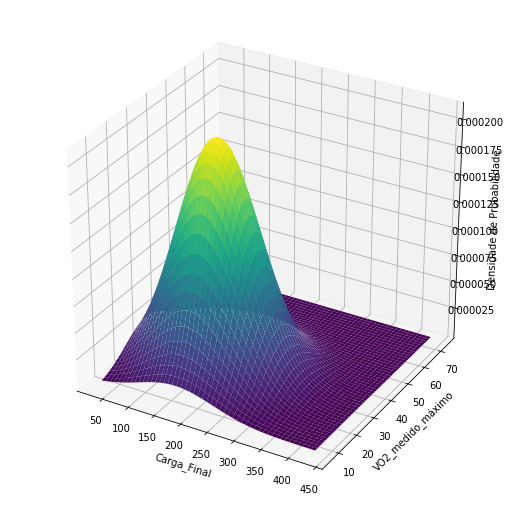

In [65]:
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

# Parâmetros da Gaussiana

var_carga = train[['Carga_Final']].var().values[0]
mean_carga = train[['Carga_Final']].mean().values[0]

var_vo2 = train[['VO2_medido_máximo']].var().values[0]
mean_vo2 = train[['VO2_medido_máximo']].mean().values[0]

## Criação de Grid para plotagem da Gaussiana multivariada 

x = np.linspace(train[['Carga_Final']].min(),train[['Carga_Final']].max(),500)
y = np.linspace(train[['VO2_medido_máximo']].min(),train[['VO2_medido_máximo']].max(),500)

X, Y = np.meshgrid(x,y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X; pos[:, :, 1] = Y
rv = multivariate_normal([mean_carga, mean_vo2], [[var_carga, 0], [0, var_vo2]])

# Plotagem 3D

fig = plt.figure(figsize=(9, 9))
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, rv.pdf(pos),cmap='viridis',linewidth=0)
ax.set_xlabel('Carga_Final')
ax.set_ylabel('VO2_medido_máximo')
ax.set_zlabel('Densidade de Probabilidade')
plt.show()

### 2.2